In this notebook, we'll explore different forms of A/B testing

# Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.stats.api as sms
import numpy as np
from math import ceil
from scipy.stats import mannwhitneyu

# Setup and Functions

In [2]:
sns.set_theme()

# Test 1: Conversion Rate

This test is based on a website which recently changed its webpage design. The previous webpage had a conversion rate of 13%, and the desired effect is an increase in conversions to 15%.

## Data Preparation

In [3]:
df1 = pd.read_csv("data/ab_data.csv")

In [4]:
df1.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [5]:
# We won't be using the time in this analysis, so we'll drop it.
df1 = df1.drop(columns=["timestamp"])

In [6]:
df1.groupby(["group", "landing_page"]).count()

user_id  converted
group     landing_page                    
control   new_page         1928       1928
          old_page       145274     145274
treatment new_page       145311     145311
          old_page         1965       1965

There are some users in the control group with the new page and vice-versa, we'll remove them.

In [7]:
df2 = df1.loc[((df1["group"] == "control") & (df1["landing_page"] == "old_page")) | ((df1["group"] == "treatment") & (df1["landing_page"] == "new_page")) ]

In [8]:
df2.groupby(["group", "landing_page"]).count()

,,user_id,converted
group,landing_page,,
control,old_page,145274,145274
treatment,new_page,145311,145311


## Effect Size and Power Calculation

We have over 145,000 datapoints for each webpage, that's plenty of data. Collecting this amount of data for an e-commerce website could take a long time and be expensive if it fails. For an hypothetical, we could calculate the minimum amount of data to collect in order to detect the desired effect of increased conversion. For that, we'll calculate the effect size and perform a power calculation to find the numbers.

In [9]:
eff_size = sms.proportion_effectsize(0.13, 0.15)
print(f"The effect size is {eff_size}")

The effect size is -0.0576728617308947


In [10]:
nobs = sms.NormalIndPower().solve_power(effect_size=eff_size, alpha=0.05, power=0.8)
nobs = ceil(nobs)
print(f"The number of observations needed to find the effect size is {nobs}")

The number of observations needed to find the effect size is 4720


Therefore, with 4720 observations, there's an 80% chance of observing the effect, if it exists.

## Hypothesis Testing

For the sake of the exercise, we'll use a sample of 4720 observations from each group, the minimum established in the last step.

In [11]:
control_df = df2[df2["group"] == "control"].sample(n=nobs, random_state=1)
treatment_df = df2[df2["group"] == "treatment"].sample(n=nobs, random_state=1)

df_test = pd.concat ([control_df, treatment_df], axis=0)

In [12]:
df_test.groupby("group")["converted"].mean()

group
control      0.118644
treatment    0.111441
Name: converted, dtype: float64

Uh oh. It looks like the treatment group has in fact a *lower* conversion rate than the control. That pretty much rules out the desired effect of increased sales, but we'll run the test anyway. Maybe it turns out the decrease effect is statistically significant.

In [13]:
count_list = [control_df["converted"].sum(), treatment_df["converted"].sum()]
nobs_list = [len(control_df), len(treatment_df)]

In [14]:
z_stat, p_val = sms.proportions_ztest(count=count_list, nobs=nobs_list)

In [15]:
print(f"The Z Statistic is {z_stat:.2f} and the p-value is {p_val:.3f}")

The Z Statistic is 1.10 and the p-value is 0.273


## Conclusion

According to our test, the result is negative: the new webpage design didn't improve the conversion rate of the website, although at least there isn't enough evidence that it hurt conversion rates either. The p-value found, much above the set target 0.05, shows evidence for the null hypothesis that the two webpage designs are not significantly different in terms of conversion.

# Test 2: Sales Figures

For this test, we'll be working on another e-commerce website. Instead of conversion rate, the goal is maximizing total amount spent and number of items bought.

As part of the exercise, we'll assume the website had an average of $1800 in sales per customer, and the desired effect was an increase of 1%.

## Data Preparation

In [16]:
df3 = pd.read_csv("data/ab_testing.csv")

In [81]:
df3.head()

,uid,spent,purchases,date,group
0,11115722,1595,5,2016-03-08,GRP B
1,11122053,498,2,2017-07-14,GRP B
2,11128688,2394,6,2017-09-17,GRP A
3,11130578,1197,3,2017-11-30,GRP A
4,11130759,1297,3,2018-01-10,GRP B


We won't be taking the country, gender or device for the purpose of this test, so the columns will be dropped.

In [18]:
df3 = df3.drop(columns=["country", "gender", "device"])

(array([ 13.,  43., 145., 231., 271., 196.,  76.,  21.,   2.,   2.]),
 array([1756.637 , 1786.8511, 1817.0652, 1847.2793, 1877.4934, 1907.7075,
        1937.9216, 1968.1357, 1998.3498, 2028.5639, 2058.778 ]),
 <BarContainer object of 10 artists>)

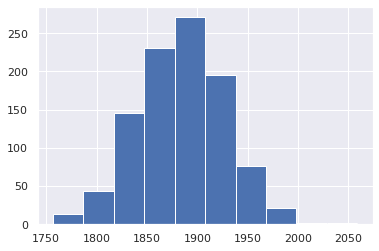

In [75]:
length = 1000
arr = np.zeros(length)
for i in range(length):
    num = df3["spent"].sample(1000).mean()
    arr[i] = num
    
plt.hist(arr)

# Effect Size and Power Calculation

For the exercise, the desired effect is an increase in sales from 1800 to 1818, or 1%. To find the minimum amount of samples necessary to find that effect, we'll perform a power calculation. We'll use the data from the group A to calculate the standard deviation.

In [73]:
std = df3[df3["group"] == "GRP A"]["spent"].std()
print(f"The standard deviation of the spent value is {std:.1f}")

eff_size = 18/std
print(f"The effect size is {eff_size:.3f}")

The standard deviation of the spent value is 1368.4
The effect size is 0.013


With the effect size, we'll calulate the needed number of observations, using a significance level of 0.05 and a power of 80%.

In [82]:
nobs = ceil(sms.TTestIndPower().solve_power(effect_size=eff_size, power=0.8, alpha=0.05))
print(f"You would need {nobs} observations to find the desired effect with the specified significance and power")

You would need 90725 observations to find the desired effect with the specified significance and power
